# Goal

We implement two algorithms here: Spectral clustering and DBScan. They are tested on a simulated dataset.

In [113]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.linalg
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix

%matplotlib inline

n_samples = 100
centers = 3
n_features = 2

# Simulate data

We simulate the dataset using the SKlearn function `make_blobs`:

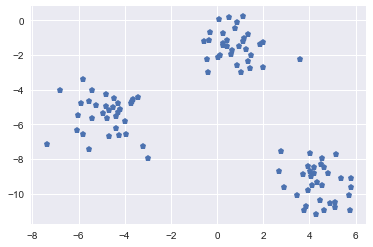

In [90]:
from sklearn.datasets import make_blobs
example_data = make_blobs(n_samples=n_samples, centers=centers, n_features=n_features)
data_points = example_data[0]
plt.plot(data_points[:, 0], data_points[:, 1], 'p')

Here is spectral clustering:

1. We calculate the similarity matrix with a Gaussian kernel
2. We retreive the nearest neighbors
3. Restrict the similarity to nearest neighbors
4. We calculate the Laplacian
5. Get the eigenvalues and eigenvectors
6. For the largest eigenvectors, perform K-means clustering
7. Return K-means labels

This algorithm is motivated by graph theory where it can be shown that zero eigenvalues correspond to connected components of the graph. Here, we look for the largest eigenvalues, those that are closest to zero.

In [114]:
X = example_data[0]

def spectal_clustering(k, c, data_points, graph_sim):

    similarity = np.zeros([n_samples, n_samples])

    # Similarity
    for i in range(n_samples):
        for j in range(n_samples):
            pi = data_points[i, :]
            pj = data_points[j, :]
            dij = (np.power(pi - pj, 2)).sum()
            similarity[i, j] = np.exp(-dij / c)        

    # Retreive nearest neighbors
    nearest_neighbors = np.argsort(-similarity, axis=1)[:, 0:graph_sim]

    # Restrict similarity to nearest neighbors
    similarity_nearest = similarity
    for i in range(n_samples):
        for j in range(n_samples):
            if not j in nearest_neighbors[i, :]:
                similarity_nearest[i, j] = 0


    # Calculate Laplacian            
    D = np.diag(similarity_nearest.sum(axis=1))
    similarity_nearest = similarity_nearest - D

    D_12 = scipy.linalg.sqrtm(D, 0.5)
    laplacian = (D_12).dot(similarity_nearest).dot(D_12)

    eig_vals, eig_vecs = np.linalg.eig(laplacian)
    eig_vals = np.real(eig_vals)
    eig_vecs = np.real(eig_vecs)

    largest_eigen_ind = (-eig_vals).argsort()[0:5]
    X = eig_vecs[:, largest_eigen_ind]

    X = X / np.sqrt((np.sum(X**2)))

    kmeans = KMeans(k)
    kmeans.fit(X)

    return kmeans.labels_

labels = spectal_clustering(4, 1, X, 10)

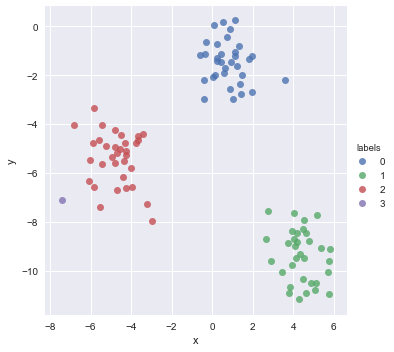

In [115]:
data = pd.DataFrame(example_data[0])
data.columns = ['x', 'y']
data['cluster'] = example_data[1]
data['labels'] = labels

sns.lmplot('x', 'y', hue='labels', data=data, fit_reg=False)

# DBScan

DBScan is a density based algorithm that is relatively straightforward to implement.

Next, we implement the [DBScan algorithm](https://en.wikipedia.org/wiki/DBSCAN). It is surprisngly simple: 

1. We initialize all labels to be unkown (-99)
2. We loop over all data points. First we check whether the point is already labelled. If yes, then we go to the next point.
3. Otherwise we query the epsilon neighbors.
4. If the point has too few neighbors, we label it noise (-1). It can become a border point of a different cluster later.
5. Then we look over the neighborhood to find the full cluster.

Finally querring the epsilon neighbors is straightforward and defined in the function below.

In [116]:
def query_epsilon_neighbors(point_ind, data, eps):
    point = data[point_ind, :]
    diffs = data - point
    inds = np.sqrt(np.power(diffs, 2).sum(axis=1)) < eps
    inds[point_ind] = False
    all_inds = np.arange(0, data.shape[0])
    return all_inds[inds]

def dbscan(x, epsilon, min_points):
    C = 0
    labels = np.zeros(x.shape[0]) - 99
    for point_index in range(x.shape[0]):

        # Point already has label
        if labels[point_index] != -99:
            continue

        # Query nearest neighbors
        N = query_epsilon_neighbors(point_index, x, epsilon)

        # If too few points in neighborhood, label as noise
        if N.shape[0] < min_points:
            labels[point_index] = -1 # -1 is noise
            continue

        # Change cluster label
        C += 1
        labels[point_index] = C

        # Set seed S
        visited = [point_index]
        N = set(N)
        while len(N) > 0:
            Q = N.pop()
            visited.append(Q)

            if labels[Q] == -1:
                labels[Q] = C

            if labels[Q] != -99:
                continue

            labels[Q] = C

            new_neighbors = set(query_epsilon_neighbors(Q, x, epsilon))
            if len(new_neighbors) > min_points:
                new_neighbors = set([i for i in new_neighbors if i not in visited])
                N = N.union(new_neighbors)
        
    return labels

labels = dbscan(data_points, epsilon = 1, min_points = 2)

We plot the results below. Looks good!

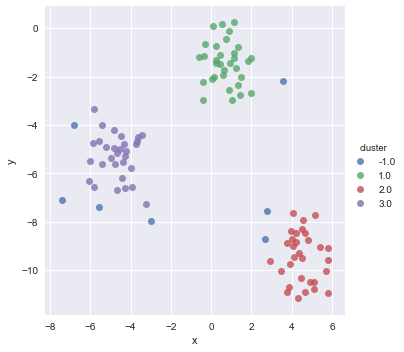

In [117]:
data = pd.DataFrame(data_points)
data.columns = ['x', 'y']
data['cluster'] = labels

sns.lmplot('x', 'y', hue='cluster', data=data, fit_reg=False)